In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-5xtb7kv0
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-5xtb7kv0
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-fn6jojgz/pyfolio_d097ec136cc94902a67cc1a18cd8893b
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-fn6jojgz/pyfolio_d097ec136cc94902a67cc1a18cd8893b
     |████████████████████████████████| 1.6 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 45.7 MB/s eta 0:00:01
     |████████████████████████████████| 280 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 107 kB 34.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 36.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 42.6 M

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from FinRL.finrl.config import config
from FinRL.finrl.marketdata.yahoodownloader import YahooDownloader
from FinRL.finrl.preprocessing.preprocessors import FeatureEngineer
from FinRL.finrl.preprocessing.data import data_split
from FinRL.finrl.env.env_stocktrading import StockTradingEnv
from FinRL.finrl.model.models import DRLAgent,DRLEnsembleAgent
from FinRL.finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [5]:
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [6]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = '2021-01-19',
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df.shape

(465816, 8)

In [8]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.860883,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,46.750000,46.937500,44.000000,30.033604,3655600.0,ADI,0
3,2000-01-03,42.428928,42.775894,41.189766,26.281422,2698899.0,ADP,0
4,2000-01-03,8.500000,8.656250,8.031250,8.052903,2845600.0,ADSK,0


In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

processed_full.shape

(524106, 17)

In [11]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 99, State Space: 991


In [12]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [13]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2000-01-01'
train_end = '2019-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-18'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [21]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

TD3_PARAMS = {
    "batch_size": 100, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
}

SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "batch_size": 64,
    "ent_coef": "auto_0.1",
}

timesteps_dict = {'a2c' : 50_000, 
                 'ppo' : 50_000, 
                 'ddpg' : 50_000,
                 'td3' : 50_000,
                 'sac' : 50_000
                 }

In [22]:
%%time
df_summary = ensemble_agent.run_ensemble_5_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 TD3_PARAMS,
                                                 SAC_PARAMS
                                                 timesteps_dict)



============Start Ensemble Strategy============
nan
turbulence_threshold:  1557.8458687039613
======Model training from:  2000-01-01 to  2019-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_7
------------------------------------
| time/                 |          |
|    fps                | 18       |
|    iterations         | 100      |
|    time_elapsed       | 27       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -141     |
|    explained_variance | -0.407   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -174     |
|    std                | 1        |
|    value_loss         | 2.52     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 18       |
|    iterations         | 200      |
|    

In [23]:
import pickle as pkl

with open('model_perf.pkl','wb+') as myfile:
    pkl.dump(df_summary,myfile)
    
with open('model_perf.pkl','rb+') as myfile:
    df_summary = pkl.load(myfile)

In [24]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,TD3 Sharpe,SAC Sharpe
0,126,2019-01-02,2019-04-03,SAC,0.481824,0.295719,0.492438,0.523009,0.571967
1,189,2019-04-03,2019-07-03,TD3,0.038774,-0.200565,-0.061352,0.150824,0.149307
2,252,2019-07-03,2019-10-02,SAC,-0.096945,-0.385075,-0.080203,-0.068455,-0.059485
3,315,2019-10-02,2020-01-02,SAC,0.385872,0.196291,0.385094,0.501322,0.565738
4,378,2020-01-02,2020-04-02,TD3,-0.327186,-0.351053,-0.283726,-0.253995,-0.290429
5,441,2020-04-02,2020-07-02,DDPG,0.496819,0.482226,0.651016,0.567248,0.604145
6,504,2020-07-02,2020-10-01,SAC,0.174141,0.121283,0.139069,0.074992,0.20116


In [25]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()


In [26]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.128916197028741


In [27]:
df_account_value

,account_value,date,daily_return,datadate
0,500000.000000,2019-04-03,NaN,2019-04-03
1,498532.829464,2019-04-04,-0.002934,2019-04-04
2,499482.507705,2019-04-05,0.001905,2019-04-05
3,497833.872416,2019-04-08,-0.003301,2019-04-08
4,495422.534419,2019-04-09,-0.004844,2019-04-09
...,...,...,...,...
436,794200.464605,2020-12-23,0.002138,2020-12-23
437,796756.156815,2020-12-24,0.003218,2020-12-24
438,797368.371439,2020-12-28,0.000768,2020-12-28
439,797763.245537,2020-12-29,0.000495,2020-12-29


<AxesSubplot:>

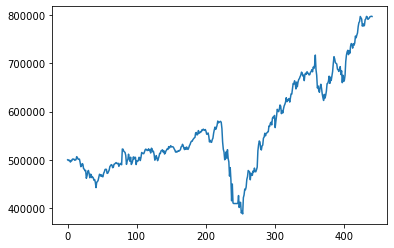

In [28]:
%matplotlib inline
df_account_value.account_value.plot()

In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.305558
Cumulative returns     0.594569
Annual volatility      0.268958
Sharpe ratio           1.128916
Calmar ratio           0.920800
Stability              0.622245
Max drawdown          -0.331840
Omega ratio            1.243919
Sortino ratio          1.599049
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.972802
Daily value at risk   -0.032681
dtype: float64


==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2019-04-03
End date,2020-12-29
Total months,20
,Backtest
Annual return,30.68%
Cumulative returns,59.553%
Annual volatility,26.926%
Sharpe ratio,1.13
Calmar ratio,0.92
Stability,0.62
Max drawdown,-33.184%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.18,2020-02-12,2020-04-03,2020-06-05,83
1,13.13,2020-09-02,2020-09-21,2020-11-06,48
2,12.67,2019-04-23,2019-06-03,2019-07-26,69
3,6.17,2019-07-26,2019-08-23,2019-09-19,40
4,4.94,2019-09-25,2019-10-08,2019-10-30,26


Stress Events,mean,min,max
New Normal,0.12%,-9.43%,8.69%


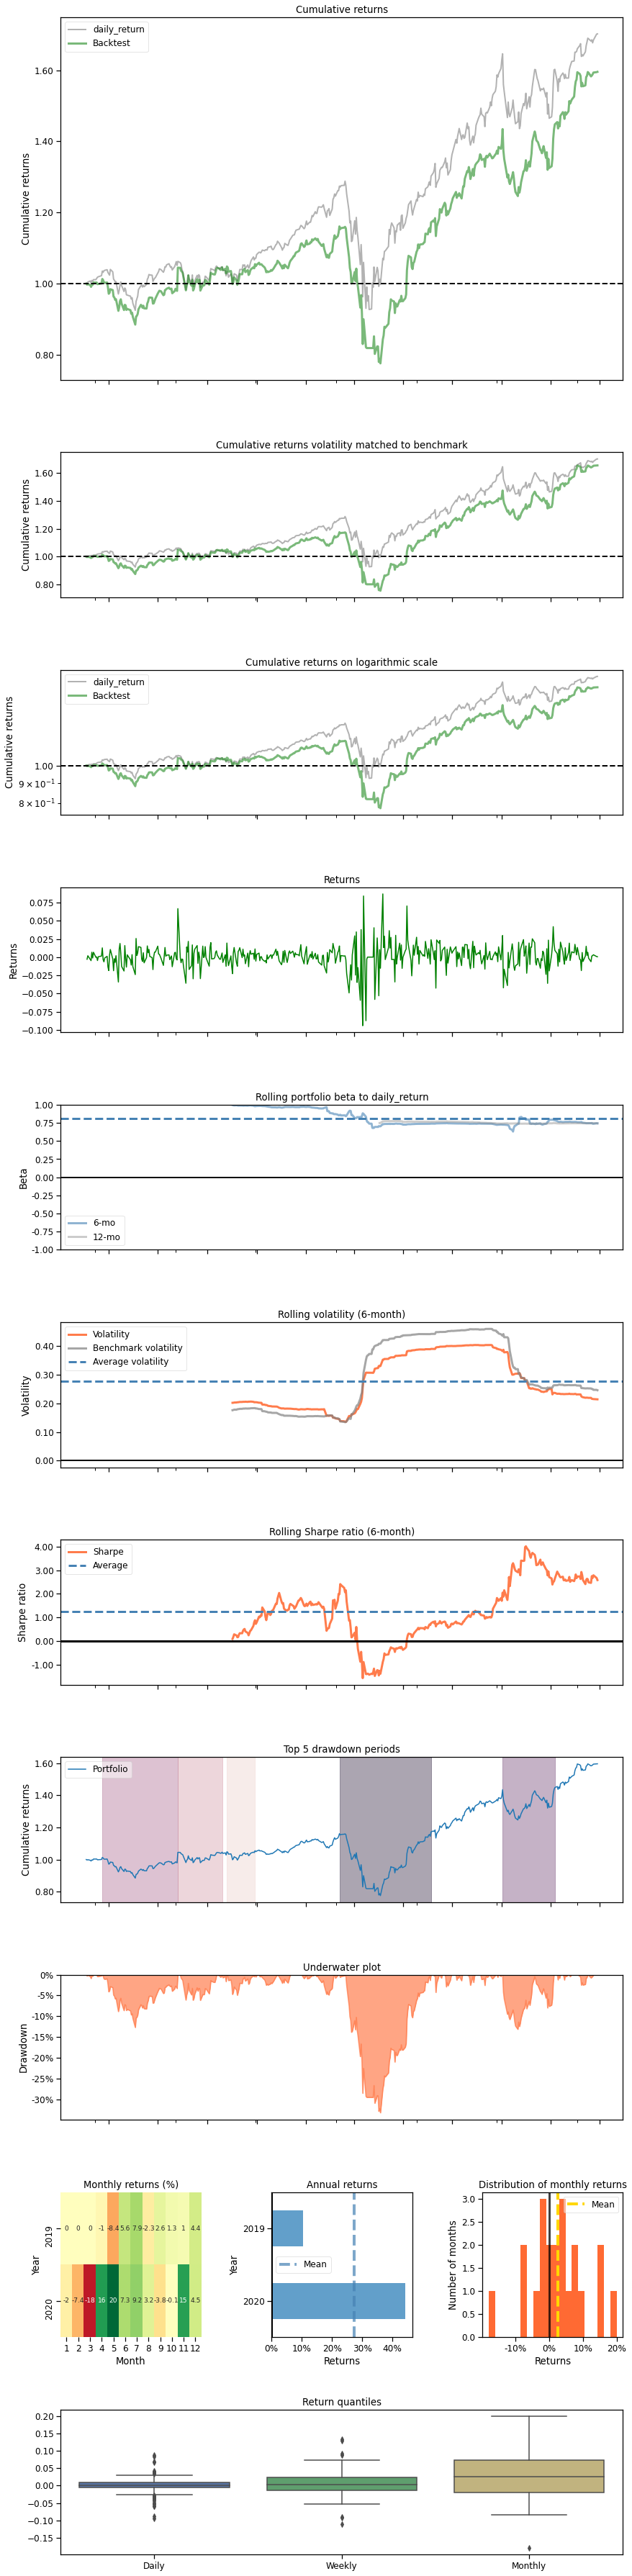

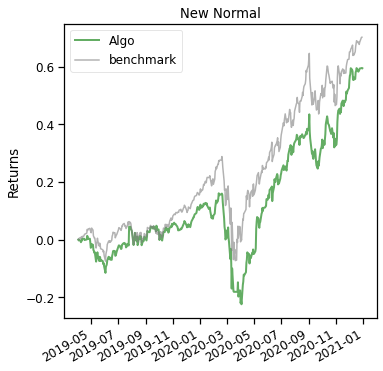

In [5]:
print("==============Compare to IHSG===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^NDX', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [32]:
with open('df_account_value.pkl','wb+') as myfile:
    pkl.dump(df_account_value,myfile)

In [4]:
import pickle as pkl

with open('df_account_value.pkl','rb+') as myfile:
    df_account_value = pkl.load(myfile)